In [2]:
import sys
sys.path.append("../models")

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, classification_report

from model_v1 import CnnModel

device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'

In [3]:
with open("../results/metrics_v1.json", "r") as f:
    metrics = json.load(f)

epochs = []
losses = []
accuracies = []

for k in sorted(metrics.keys(), key=lambda x: int(x)):
    epochs.append(int(k) + 1)
    losses.append(metrics[k]["loss"])
    accuracies.append(metrics[k]["accuracy"])

df = pd.DataFrame({
    "epoch": epochs,
    "loss": losses,
    "accuracy": accuracies
})

df


,epoch,loss,accuracy
0,1,346.698685,0.514553
1,2,342.340671,0.558526
2,3,334.876854,0.578513
3,4,331.615174,0.588882
4,5,330.007366,0.596002
5,6,327.719715,0.603748
6,7,327.833225,0.603498
7,8,326.506759,0.602249
8,9,325.348433,0.606996
9,10,325.230631,0.606871


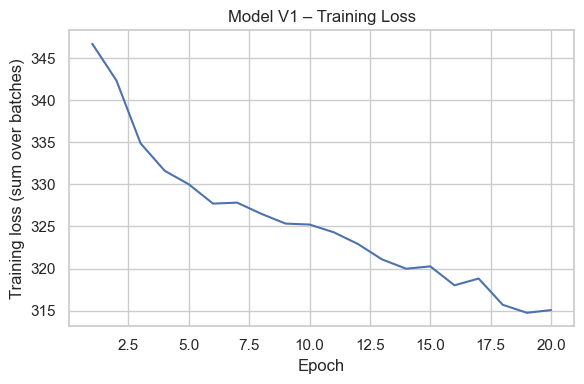

In [4]:
sns.set(style="whitegrid")

plt.figure(figsize=(6, 4))
plt.plot(df["epoch"], df["loss"])
plt.xlabel("Epoch")
plt.ylabel("Training loss (sum over batches)")
plt.title("Model V1 – Training Loss")
plt.tight_layout()
os.makedirs("../results", exist_ok=True)
plt.savefig("../results/loss_curve_v1.png", dpi=300)
plt.show()


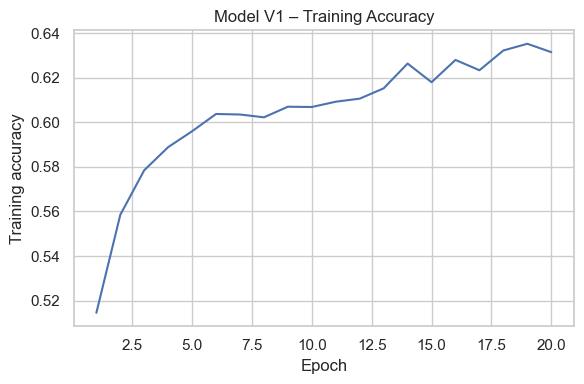

In [5]:
plt.figure(figsize=(6, 4))
plt.plot(df["epoch"], df["accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Training accuracy")
plt.title("Model V1 – Training Accuracy")
plt.tight_layout()
plt.savefig("../results/accuracy_curve_v1.png", dpi=300)
plt.show()


In [6]:
testTransform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

testData = datasets.ImageFolder("../data/test", transform=testTransform)
testLoader = DataLoader(testData, batch_size=32, shuffle=False)

len(testData), testData.classes


(2023, ['cats', 'dogs'])

In [7]:
model = CnnModel().to(device)
state = torch.load("../models/model_v1.pth", map_location=device)
model.load_state_dict(state)
model.eval()


CnnModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (adapt): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=32, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [8]:
allTargets = []
allPreds = []

with torch.no_grad():
    for imgs, labels in testLoader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        out = model(imgs)
        _, preds = torch.max(out, 1)

        allTargets.extend(labels.cpu().numpy().tolist())
        allPreds.extend(preds.cpu().numpy().tolist())

allTargets = np.array(allTargets)
allPreds = np.array(allPreds)

cm = confusion_matrix(allTargets, allPreds)
cm, cm.shape


(array([[612, 399],
        [293, 719]]),
 (2, 2))

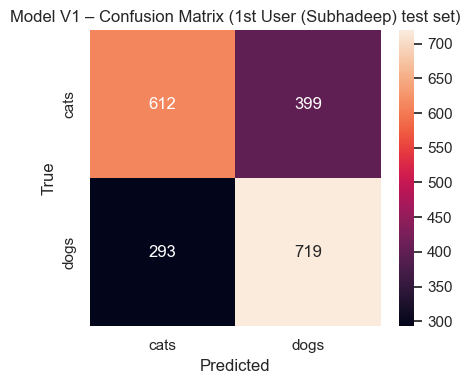

              precision    recall  f1-score   support

        cats       0.68      0.61      0.64      1011
        dogs       0.64      0.71      0.68      1012

    accuracy                           0.66      2023
   macro avg       0.66      0.66      0.66      2023
weighted avg       0.66      0.66      0.66      2023



In [9]:
classes = testData.classes

plt.figure(figsize=(4.5, 4))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Model V1 – Confusion Matrix (1st User (Subhadeep) test set)")
plt.tight_layout()
plt.savefig("../results/confusion_matrix_v1.png", dpi=300)
plt.show()

print(classification_report(allTargets, allPreds, target_names=classes))


In [10]:
#GradCam
import torch.nn.functional as F
from PIL import Image

def getGradCam(model, imgTensor, targetLayer):
    activations = []
    gradients = []

    def fwdHook(module, inp, out):
        activations.append(out.detach())

    def bwdHook(module, gradIn, gradOut):
        gradients.append(gradOut[0].detach())

    handleF = targetLayer.register_forward_hook(fwdHook)
    handleB = targetLayer.register_backward_hook(bwdHook)

    model.zero_grad()
    out = model(imgTensor)
    _, predClass = torch.max(out, 1)
    score = out[0, predClass]
    score.backward()

    acts = activations[0][0]      
    grads = gradients[0][0]       

    weights = grads.mean(dim=(1, 2))  
    cam = torch.zeros_like(acts[0])

    for w, a in zip(weights, acts):
        cam += w * a

    cam = cam.cpu().numpy()
    cam = np.maximum(cam, 0)
    if cam.max() != 0:
        cam = cam / cam.max()

    handleF.remove()
    handleB.remove()

    return cam, int(predClass.item())


In [11]:
os.makedirs("../results/gradcam", exist_ok=True)

def saveGradCamForSamples(numSamples=5):
    model.eval()
    count = 0

    for idx in range(len(testData)):
        if count >= numSamples:
            break

        img, label = testData[idx]
        imgTensor = img.unsqueeze(0).to(device)

        cam, predClass = getGradCam(model, imgTensor, model.conv2)

        imgNp = img.permute(1, 2, 0).numpy()  

        heatmap = plt.cm.jet(cam)[..., :3]
        heatmap = np.array(Image.fromarray((heatmap * 255).astype(np.uint8)).resize((256, 256))) / 255.0

        overlay = 0.5 * imgNp + 0.5 * heatmap

        overlay = np.clip(overlay, 0, 1)

        trueName = classes[label]
        predName = classes[predClass]

        plt.figure(figsize=(6, 3))
        plt.subplot(1, 2, 1)
        plt.imshow(imgNp)
        plt.axis("off")
        plt.title(f"Original\nTrue: {trueName}")

        plt.subplot(1, 2, 2)
        plt.imshow(overlay)
        plt.axis("off")
        plt.title(f"Grad-CAM\nPred: {predName}")

        fname = f"../results/gradcam/sample_{idx}.png"
        plt.tight_layout()
        plt.savefig(fname, dpi=300)
        plt.close()

        count += 1

saveGradCamForSamples(numSamples=5)


c:\Users\Vishal\Desktop\Collab_Task\collaborative_cnn_team04\venv\Lib\site-packages\torch\nn\modules\module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
